In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [23]:
class DotaMiniDataset(Dataset):
    def __init__(self, img_dir, label_dir, transforms=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.imgs = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg",".png",".bmp"))]

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.rsplit('.',1)[0]+'.txt')

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Parse txt labels
        boxes = []
        labels = []
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                # Chỉ parse các dòng bbox (có 10 phần tử)
                if len(parts) != 10:
                    continue
                coords = list(map(float, parts[:8]))
                xs = coords[0::2]
                ys = coords[1::2]
                x_min, y_min = min(xs), min(ys)
                x_max, y_max = max(xs), max(ys)
                boxes.append([x_min, y_min, x_max, y_max])

                cls = parts[8]
                if cls == "small-vehicle":
                    labels.append(1)
                elif cls == "large-vehicle":
                    labels.append(2)
                else:
                    labels.append(0)  # fallback

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        if self.transforms:
            img = self.transforms(img)
        else:
            img = F.to_tensor(img)

        return img, target

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
train_dataset = DotaMiniDataset("data/train", "data/labels")
test_dataset  = DotaMiniDataset("data/test", "data/labels")

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [26]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 3  # background + small-vehicle + large-vehicle
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [27]:
import torch.optim as optim
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [28]:
num_epochs = 2  # demo few-shot
model.train()
for epoch in range(num_epochs):
    for imgs, targets in train_loader:
        imgs = list(img.to(device) for img in imgs)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {losses.item():.4f}")

Epoch 1, Loss: 0.8972
Epoch 2, Loss: 0.4313


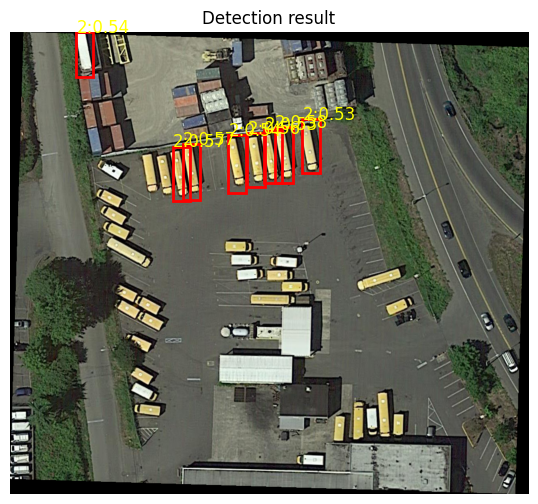

In [36]:
model.eval()
for imgs, targets in test_loader:
    img = imgs[0]  # đã là tensor [C,H,W]
    img_tensor = img.unsqueeze(0).to(device)  # add batch dim

    with torch.no_grad():
        outputs = model(img_tensor)

    # visualize
    img_np = img.permute(1,2,0).cpu().numpy()  # C,H,W -> H,W,C
    fig, ax = plt.subplots(1, figsize=(10,6))
    ax.imshow(img_np)

    for box, label, score in zip(outputs[0]['boxes'], outputs[0]['labels'], outputs[0]['scores']):
        if score > 0.5:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1, f'{label}:{score:.2f}', color='yellow', fontsize=12)

    ax.set_title("Detection result")
    plt.axis('off')
    plt.show()